In [1]:
cd ../src

C:\Users\Sam\smore\src


In [2]:
%load_ext autoreload
%autoreload 2

In [44]:
from pathlib import Path
from utils.plot import *
from utils.test_loader import TestSet
from utils.preprocess import open_interp_rotate
from utils.rotate import rotate_vol_2D, inv_rotate_vols_2D
from torch.utils.data import DataLoader
import torch

In [4]:
fpath = Path("../SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")

In [5]:
n_rots = 2

In [8]:
res = open_interp_rotate(
    img_fpath=fpath,
    n_rots=n_rots,
)
imgs_rot, affine, header, pads, acq_res, k, blur_k, lr_axis = res

========== PREPROCESSING IMAGE ==========
Interpolating through-plane...
	Elapsed time: 3.8500s
Creating 2 rotations...
	Elapsed time: 0.1590s


In [9]:
data_loader = DataLoader(
    TestSet(imgs_rot),
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
)

In [27]:
aa_vols = [[] for _ in range(n_rots)]
for rot_batch in data_loader:
    aa_batches = [batch for batch in rot_batch]
    for i, aa_batch in enumerate(aa_batches):
        aa_vols[i].extend(aa_batch)
    
aa_vols = [torch.cat(aa_vol, dim=0).numpy() for aa_vol in aa_vols]

In [31]:
# rotate AA vols by 90 degrees in-plane
# so we can apply SR model on orthogonal axis
aa_vols = [rotate_vol_2D(aa_vol, 90) for aa_vol in aa_vols]

In [32]:
aa_data_loader = DataLoader(
    TestSet(aa_vols),
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
)

In [37]:
sr_vols = [[] for _ in range(n_rots)]
for rot_batch in aa_data_loader:
    sr_batches = [batch for batch in rot_batch]
    for i, sr_batch in enumerate(sr_batches):
        sr_vols[i].extend(sr_batch)
    
sr_vols = [torch.cat(sr_vol, dim=0).numpy() for sr_vol in sr_vols]

In [40]:
# rotate SR vols by 270 degrees in-plane
# to return to original orientation
sr_vols = [rotate_vol_2D(sr_vol, 270) for sr_vol in sr_vols]

In [46]:
# align all resultant rotations in sr_vols
final_preds = inv_rotate_vols_2D(sr_vols)

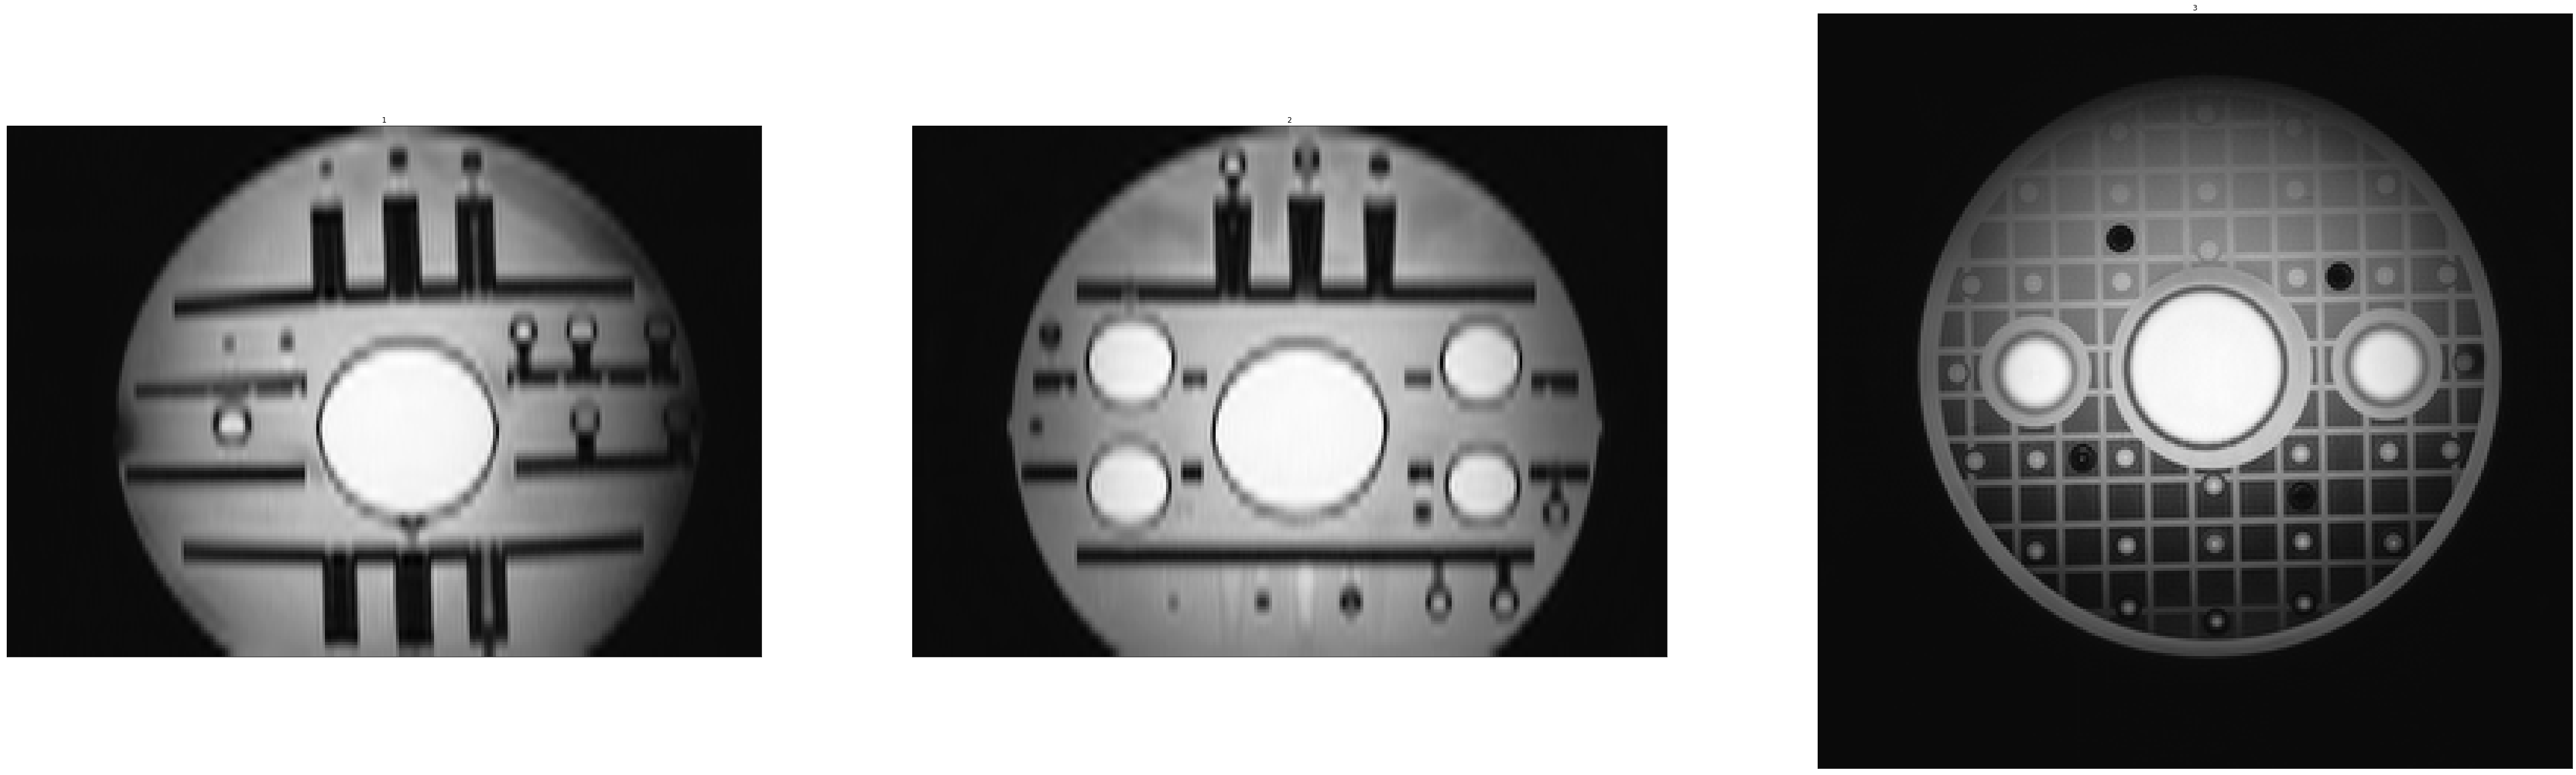

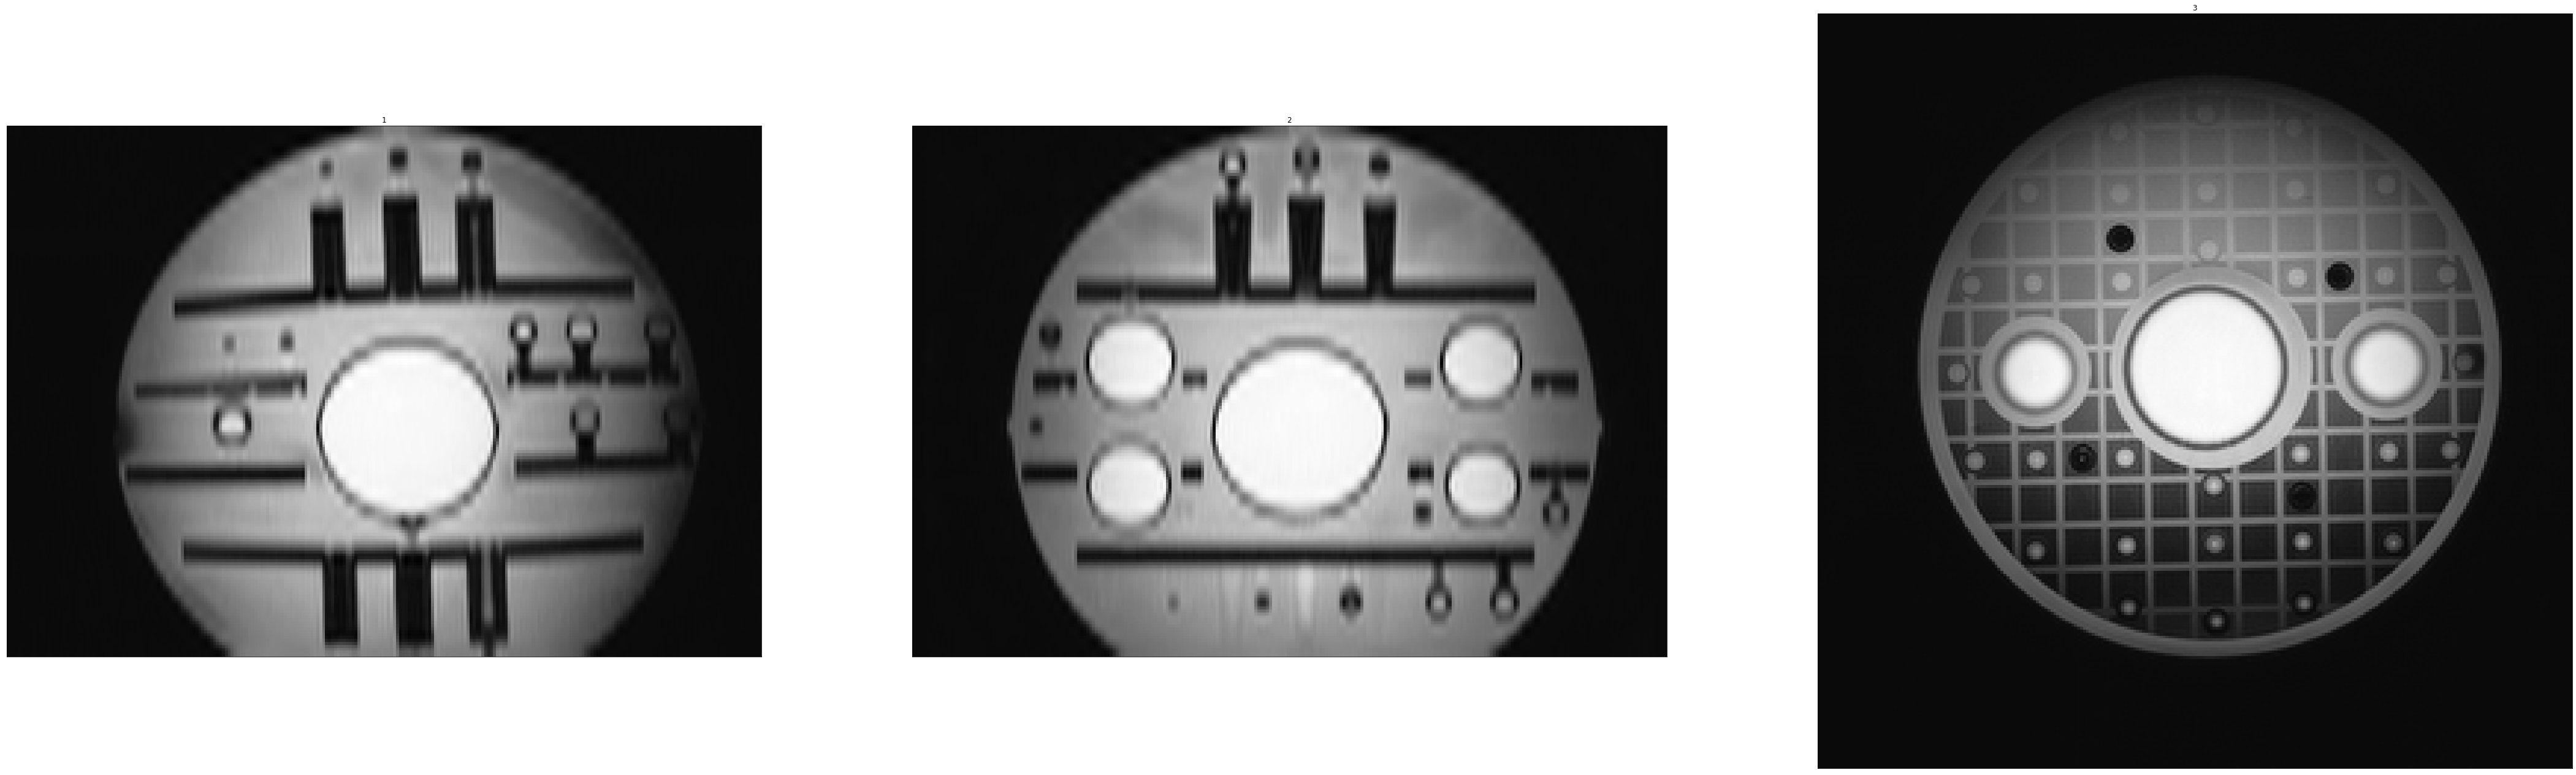

In [47]:
for x in final_preds:
    center_vol_plot(x)

In [48]:
pads

((0, 0), (0, 0), (0, 0))